# Importing Packages

In [199]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 0.1.6.1 installed at /home/yanza15/.local/lib/python2.7/site-packages/camb


In [200]:
sys.path.append('/home/yanza15/software/Compos_new/sources')
import compos_new as compos
reload(compos)

<module 'compos_new' from '/home/yanza15/software/Compos_new/sources/compos_new.pyc'>

# Setup Cosmological Parameters

In [201]:
omb = 0.0486
om0 = 0.3089
omc = om0 - omb
omk = 0
omq = 1 - om0
TCMB = 2.7255

H0 = 67.74
h = H0 / 100.
ombh2 = omb * h ** 2
omch2 = omc * h ** 2
omk = 0
ns = 0.9667


In [202]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings,
#with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.0, omk=omk,num_massive_neutrinos=0,
                   nnu=3, YHe=None, meffsterile=0.0,
                   standard_neutrino_neff=3., tau=0.0, 
                   TCMB=TCMB)
pars.InitPower.set_params(ns=ns, r=0, pivot_scalar=1)


In [203]:
compos_comsmo = compos.cosmology(om0 = om0, omb=omb, H0=H0, T_CMB=TCMB, omq=omq, n_s=ns)

# Linear Matter Power Spectra 

## CAMB Linear MPS

In [204]:
pars.set_matter_power(redshifts=[0., 2., 4], kmax=10)
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, lpk_camb = results.get_linear_matter_power_spectrum()


Note: redshifts have been re-sorted (earliest first)


## Transferfunction

In [205]:
tf = results.get_matter_transfer_data()
kh_tf = tf.transfer_data[0,:,0]
delta = tf.transfer_data[model.Transfer_tot-1,:,0]
tf_camb = delta / delta[0]

In [206]:
s8 = tf.sigma_8
compos_comsmo.sigma8 = s8[-1][0]
lp_class = compos.matterps(compos_comsmo)
tf_compos = lp_class.transfunction(kh_tf*h)

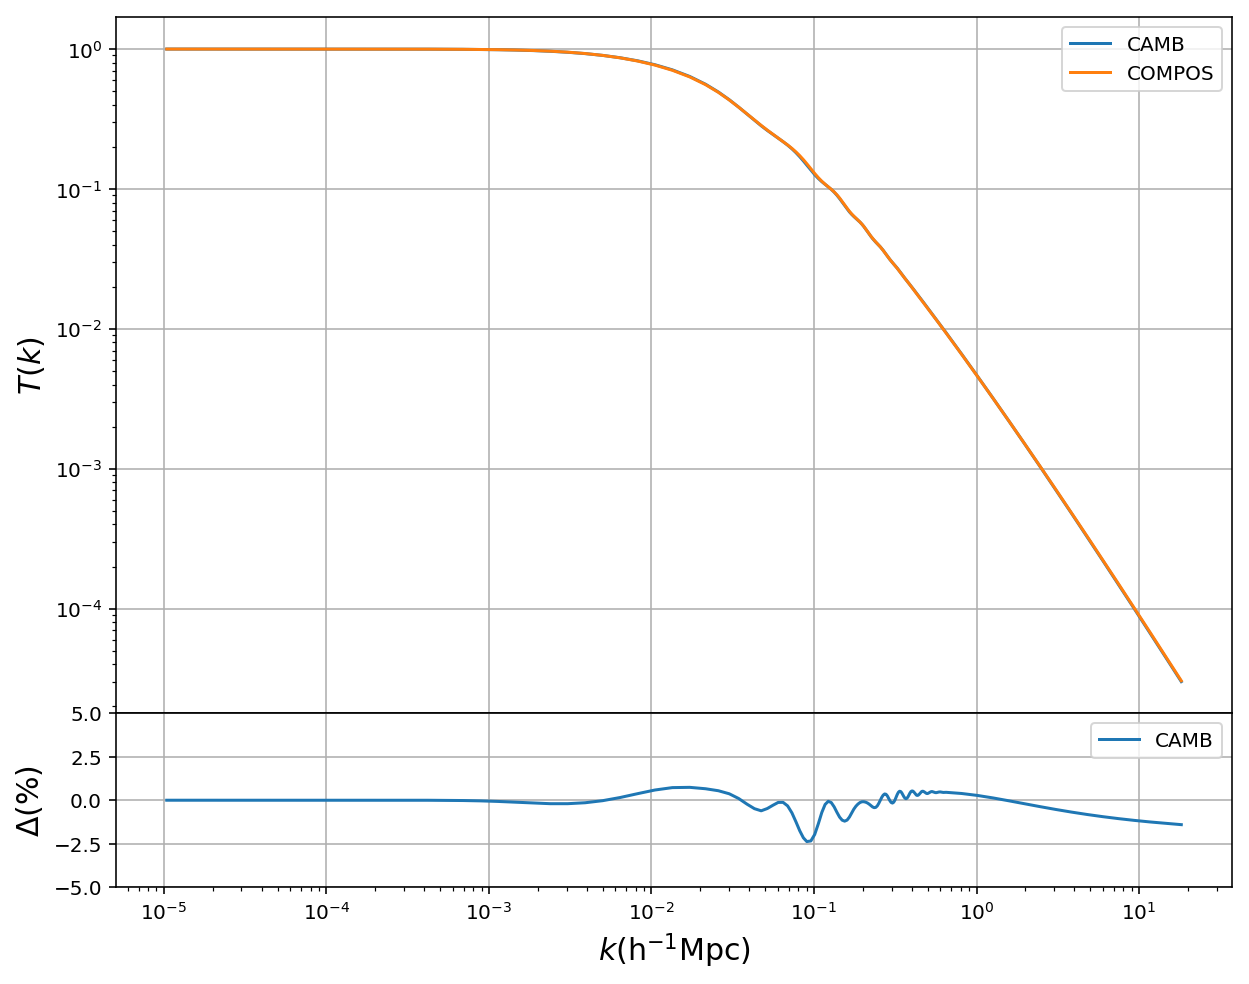

In [207]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 

ax1 = plt.subplot(gs[0])

plt.loglog(kh_tf, tf_camb,label = 'CAMB')
plt.loglog(kh_tf, tf_compos, label='COMPOS')

ax1.legend()
ax1.grid()
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r'$T(k)$',fontsize=15)
ax2 = plt.subplot(gs[1])
ax2.semilogx(kh_tf, (tf_camb-tf_compos)/tf_camb*100,label = 'CAMB')
ax2.legend(loc=1)
ax2.set_ylim(-5, 5)
ax2.grid()
ax2.set_xlabel(r'$k(\mathrm{h^{-1}Mpc})$',fontsize=15)
ax2.set_ylabel(r'$\Delta(\%)$',fontsize = 15)
plt.subplots_adjust(hspace=0)

## COMPOS Linear MPS

In [208]:
reload(compos)
k = kh * h

lpk_compos_0 = lp_class.normalizedmp(k)
lpk_compos_2 = lp_class.normalizedmp(k, z=2)
lpk_compos_4 = lp_class.normalizedmp(k, z=4)

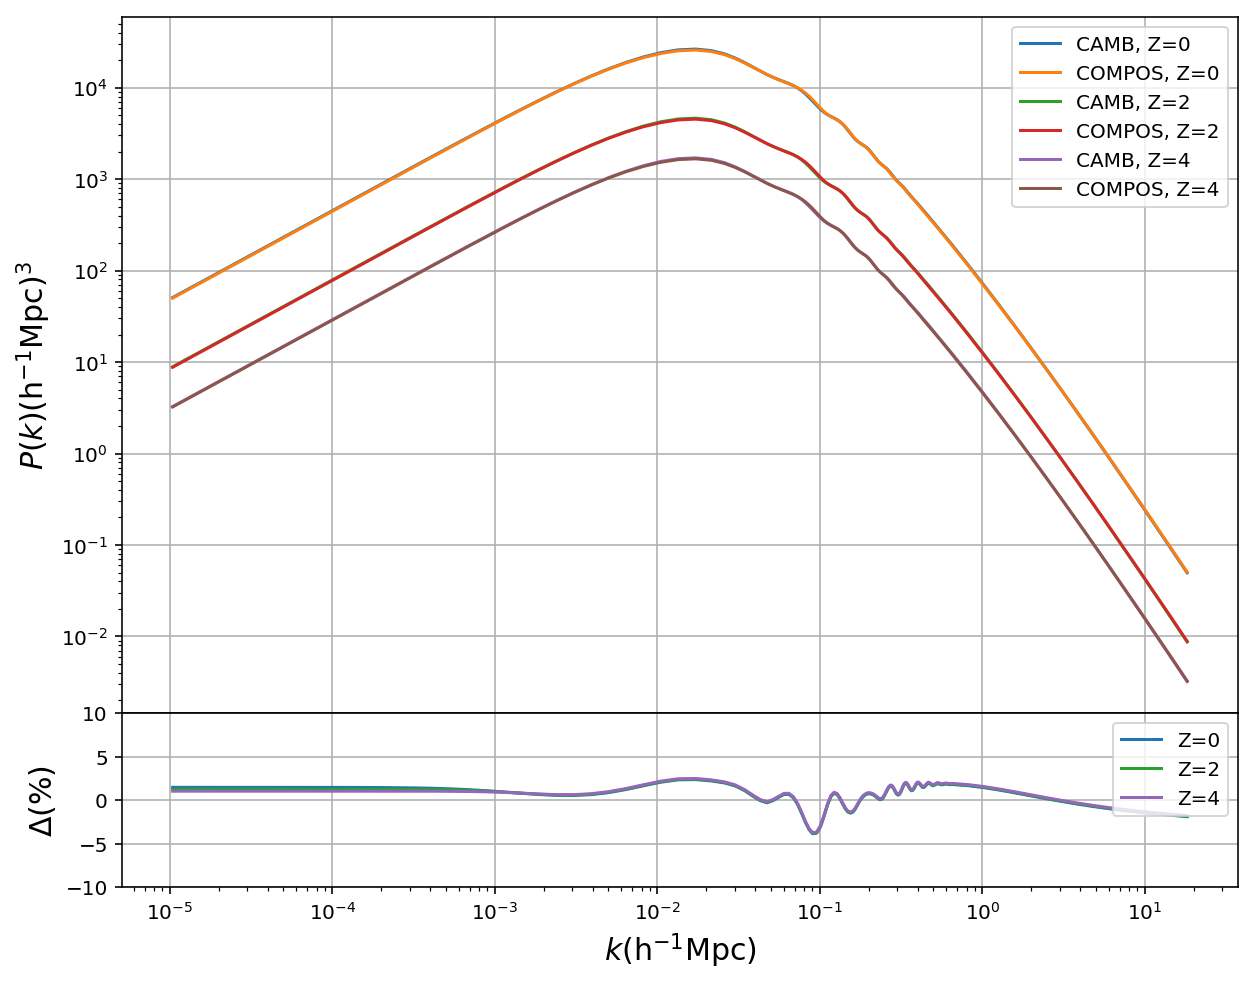

In [209]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 

ax1 = plt.subplot(gs[0])
ax1.loglog(kh, lpk_camb[0], color = 'C0', label='CAMB, Z=0')
ax1.loglog(kh, lpk_compos_0*h**3, color = 'C1', label='COMPOS, Z=0')

ax1.loglog(kh, lpk_camb[1], color = 'C2', label='CAMB, Z=2')
ax1.loglog(kh, lpk_compos_2*h**3, color = 'C3', label='COMPOS, Z=2')

ax1.loglog(kh, lpk_camb[2], color = 'C4', label='CAMB, Z=4')
ax1.loglog(kh, lpk_compos_4*h**3, color = 'C5', label='COMPOS, Z=4')
ax1.legend()
ax1.grid()
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r'$P(k)(\mathrm{h^{-1}Mpc})^3$',fontsize=15)
ax2 = plt.subplot(gs[1])
ax2.semilogx(kh, (lpk_camb[0]-(lpk_compos_0*h**3)) / lpk_camb[0]*100, color='C0', label='Z=0')
ax2.semilogx(kh, (lpk_camb[1]-(lpk_compos_2*h**3)) / lpk_camb[1]*100, color='C2', label='Z=2')
ax2.semilogx(kh, (lpk_camb[2]-(lpk_compos_4*h**3)) / lpk_camb[2]*100, color='C4', label='Z=4')
ax2.legend(loc=1)
ax2.set_ylim(-10, 10)
ax2.grid()
ax2.set_xlabel(r'$k(\mathrm{h^{-1}Mpc})$',fontsize=15)
ax2.set_ylabel(r'$\Delta(\%)$',fontsize = 15)
plt.subplots_adjust(hspace=0)

# Non-linear Matter Power Spectra

## CAMB Non-linear MPS

In [210]:
pars.set_matter_power(redshifts=[0., 2., 4], kmax=1e3)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
kh_nl, z, nlpk_camb = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1e3, npoints = 200)
s8 = np.array(results.get_sigma8())

Note: redshifts have been re-sorted (earliest first)


## COMPOS Non-linear MPS

In [211]:
reload(compos)
k = kh_nl * h
nlp_class = compos.halofit(compos_comsmo)
nlpk_compos_0 = nlp_class.nlpowerspec(k, z=0)
nlpk_compos_2 = nlp_class.nlpowerspec(k, z=2)
nlpk_compos_4 = nlp_class.nlpowerspec(k, z=4)

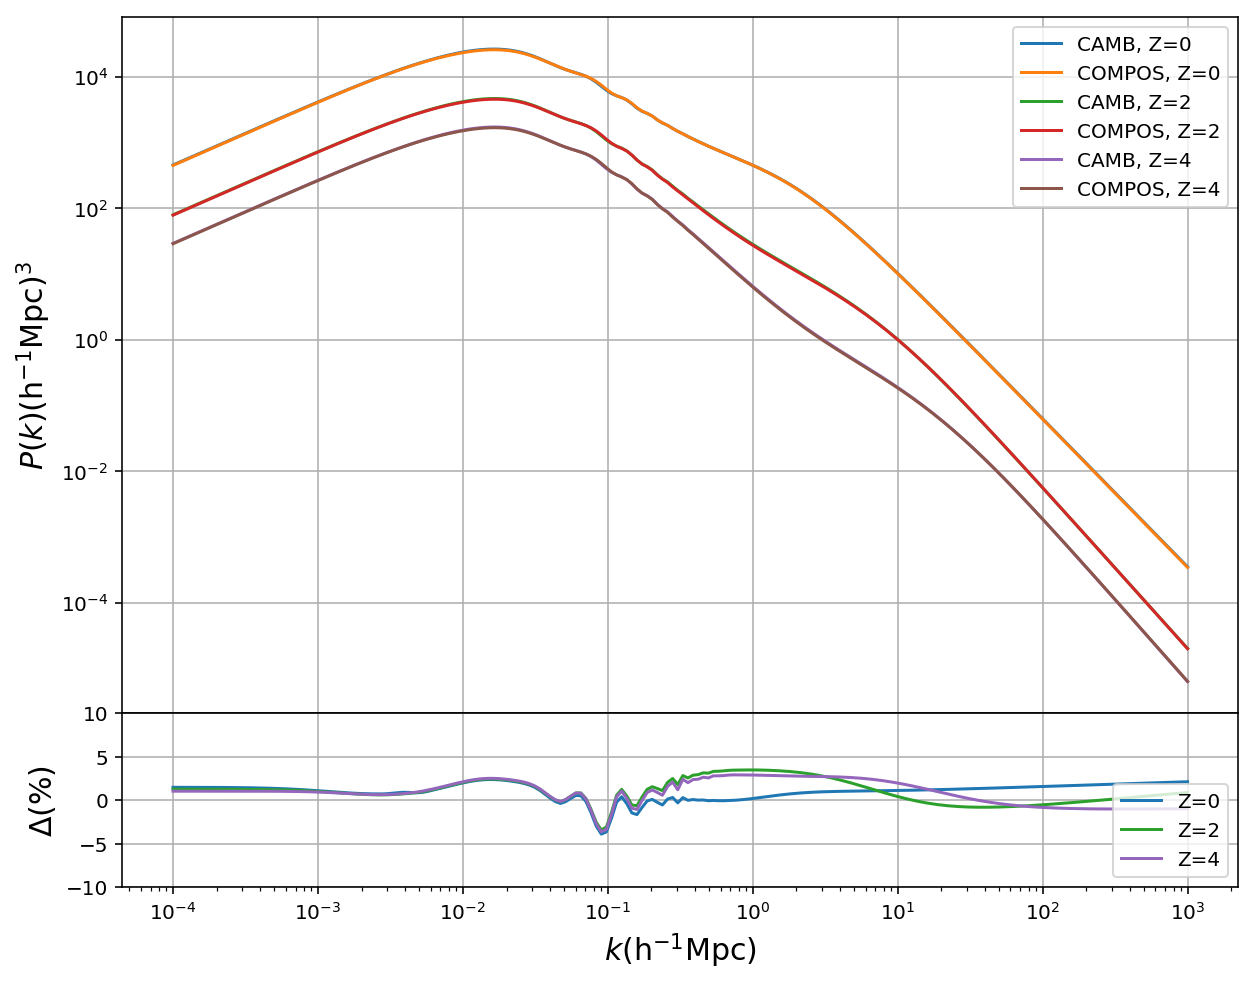

In [212]:
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 

ax1 = plt.subplot(gs[0])
ax1.loglog(kh_nl, nlpk_camb[0], color = 'C0', label='CAMB, Z=0')
ax1.loglog(kh_nl, nlpk_compos_0*h**3, color = 'C1', label='COMPOS, Z=0')

ax1.loglog(kh_nl, nlpk_camb[1], color = 'C2', label='CAMB, Z=2')
ax1.loglog(kh_nl, nlpk_compos_2*h**3, color = 'C3', label='COMPOS, Z=2')

ax1.loglog(kh_nl, nlpk_camb[2], color = 'C4', label='CAMB, Z=4')
ax1.loglog(kh_nl, nlpk_compos_4*h**3, color = 'C5', label='COMPOS, Z=4')
ax1.legend()
ax1.grid()
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r'$P(k)(\mathrm{h^{-1}Mpc})^3$',fontsize=15)
ax2 = plt.subplot(gs[1])
ax2.semilogx(kh_nl, (nlpk_camb[0]-(nlpk_compos_0*h**3)) / nlpk_camb[0]*100, color='C0', 
             label='Z=0')
ax2.semilogx(kh_nl, (nlpk_camb[1]-(nlpk_compos_2*h**3)) / nlpk_camb[1]*100, color='C2', 
             label='Z=2')
ax2.semilogx(kh_nl, (nlpk_camb[2]-(nlpk_compos_4*h**3)) / nlpk_camb[2]*100, color='C4', 
             label='Z=4')
ax2.legend()
ax2.set_ylim(-10, 10)
ax2.grid()
ax2.set_xlabel(r'$k(\mathrm{h^{-1}Mpc})$', fontsize=15)
ax2.set_ylabel(r'$\Delta(\%)$', fontsize=15)
plt.subplots_adjust(hspace=0)